## **FDS project, winter semester 2023**

#### Tommaso Leonardi, Arianna Paolini, Stefano Saravalle, Paolo Cursi, Pietro Signorino
<leonardi.1914546@studenti.uniroma1.it>, <paolini.1943164@studenti.uniroma1.it>, <saravalle.1948684@studenti.uniroma1.it>, <paoloc1999@gmail.com>, <signorino.2149741@studenti.uniroma1.it>

# **Student Performance Analysis & Prediction**

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

### **Data Preprocessing**

In [2]:
#loading the dataset tables
courses = pd.read_csv('./data/courses.csv')  #22 rows for courses (modules) and their presentations
assess = pd.read_csv('./data/assessments.csv')  #206 rows of assessments for module-presentations (including the final exam)
results = pd.read_csv('./data/studentAssessment.csv') #173,912 rows for the scores obtained by students in the asssesments
studs = pd.read_csv('./data/studentInfo.csv') #32,593 rows for demographic information on students and their results in module-presentations
registr = pd.read_csv('./data/studentRegistration.csv') #32,593 rows for student registration/unregistration on module-presentations
vle = pd.read_csv('./data/studentVle.csv') #10,655,280 rows for daily student interactions with online resources for a module-presentation
materials = pd.read_csv('./data/vle.csv') #6,364 rows for the materials available on the Virtual Learning Environment

The _Open University Learning Analytics dataset_ that we are considering has the following structure: 

 <img src="https://analyse.kmi.open.ac.uk/resources/images/model.png" alt="dataset structure" style="height: 500px; width:500px;"/>


(https://analyse.kmi.open.ac.uk/open_dataset)



In [3]:
#DONE: definire i task -> regressione/classificazione dello score per ogni assessment
#DONE: trasformare valori categorici in numeri
#DONE: normalizzare i dati
#?: pulire i dati
#DONE: mostrare la distribuzione dei dati con grafici
#DONE: fare split tra training e test set (considerare cross validation)


Since our goal is to predict the score of each student in any assessment belonging to a specific module presentation, we consider the demographic information about students (from the table *studentInfo*) and their accessess to online resources in the Virtual Learning Environment (VLE) for each course (from the tables *studentVle* and *vle*) as features for our models. 

We also take in account the assessment type and weigth (from the table *assessments*) and the time the student spent before submitting it (from the table *studentAssessment*). 

The target value to predict is the score from the *studentAssessment* table, which ranges from 0 to 100.

In [4]:
#dropping some features
studs = studs.drop("final_result", axis=1)
registr = registr.drop("date_unregistration", axis=1)
materials = materials.drop(["week_from", "week_to"], axis=1)
vle = vle.drop("date", axis=1)
results = results.drop("is_banked", axis=1)

#remove Nan values in studs 'imd_band' (amounts to around 7000 total assessment results)
studs=studs.dropna()

#remove students with 'date registration' that is null (amounts to 7 total assessment results)
registr=registr.dropna()

#match info about a student and his date of registration to a module presentation
studs = studs.merge(registr, how="inner", on=["code_module", "code_presentation","id_student"])

#match a student's interactions with an online resource with the type of the resource
vle = vle.merge(materials, how="inner", on=["code_module", "code_presentation","id_site"] )
vle = vle.drop("id_site", axis=1)

#group the interactions by resource type and add a feature to consider the total sum of clicks for each resource type
temp = vle.groupby(["code_module", "code_presentation", "id_student", "activity_type"]).sum().reset_index()
for x in temp["activity_type"].unique():
    temp[x+"_clicks"] = np.where(temp["activity_type"]==x, temp["sum_click"], 0)
temp = temp.drop(["activity_type","sum_click"], axis=1)
temp = temp.groupby(["code_module", "code_presentation", "id_student"]).sum().reset_index()

#match student's information with his interactions on the VLE for a specific module presentation and fill nan with 0
studs = studs.merge(temp, how="left", on=["code_module", "code_presentation", "id_student"])
studs= studs.fillna(0)

#remove assessments without 'date'=nan and results with 'score'=nan
assess=assess.dropna()
results=results.dropna()
#a=results.merge(assess[assess['date'].isnull()], how="inner", on=["id_assessment"]) #only 2865 instances are removed

#match assessments with students scores
assess = assess.merge(results, how="inner", on="id_assessment")

#substitute date in assessment and date_submitted in results with their difference (to be considered as a time delay from expected submission)
assess["submission_delay"] = assess["date_submitted"] - assess["date"] #"date" is the deadline for the assessment
assess = assess.drop(["date","date_submitted"], axis=1)

#match students with their results
df = studs.merge(assess, how="inner", on=["code_module", "code_presentation","id_student"])

#remove ids from the features
df = df.drop(["code_module","code_presentation","id_student","id_assessment"], axis=1) 
print(df.shape) #163387 total rows

(163387, 33)


Some of the features in the dataset have *string* values (e.g. 'gender' has values {'M', 'F'}). 

We convert those features to integer values. The list *to_be_converted* contains the names of such features.

In [5]:
df["highest_education"] = df["highest_education"].replace({"No Formal quals":0, "Lower Than A Level":1, "A Level or Equivalent": 2, 
                                                           "HE Qualification":3, "Post Graduate Qualification":4 })

df["imd_band"] = df["imd_band"].replace({"0-10%":0, "10-20":1, "20-30%": 2, "30-40%":3, "40-50%":4, "50-60%":5,
                                          "60-70%":6, "70-80%":7, "80-90%":8, "90-100%":9 })

df["age_band"] = df["age_band"].replace({"0-35":0, "35-55":1, "55<=": 2})

to_be_converted = ["gender", "region", "disability", "assessment_type"]

for column_name in to_be_converted:

    values = set(df[column_name].tolist())
    print(f"Values in '{column_name}' column: {values}")

    mapping = {x : y for y,x in enumerate(values)}
    print(f"Mapping from string values to numerical using the following dictionary: {mapping}")

    df[column_name] = df[column_name].map(mapping)

    print("\n==================================================\n")


Values in 'gender' column: {'F', 'M'}
Mapping from string values to numerical using the following dictionary: {'F': 0, 'M': 1}


Values in 'region' column: {'East Midlands Region', 'Scotland', 'South Region', 'East Anglian Region', 'North Western Region', 'London Region', 'North Region', 'South West Region', 'South East Region', 'Wales', 'Yorkshire Region', 'Ireland', 'West Midlands Region'}
Mapping from string values to numerical using the following dictionary: {'East Midlands Region': 0, 'Scotland': 1, 'South Region': 2, 'East Anglian Region': 3, 'North Western Region': 4, 'London Region': 5, 'North Region': 6, 'South West Region': 7, 'South East Region': 8, 'Wales': 9, 'Yorkshire Region': 10, 'Ireland': 11, 'West Midlands Region': 12}


Values in 'disability' column: {'N', 'Y'}
Mapping from string values to numerical using the following dictionary: {'N': 0, 'Y': 1}


Values in 'assessment_type' column: {'Exam', 'TMA', 'CMA'}
Mapping from string values to numerical using the followin

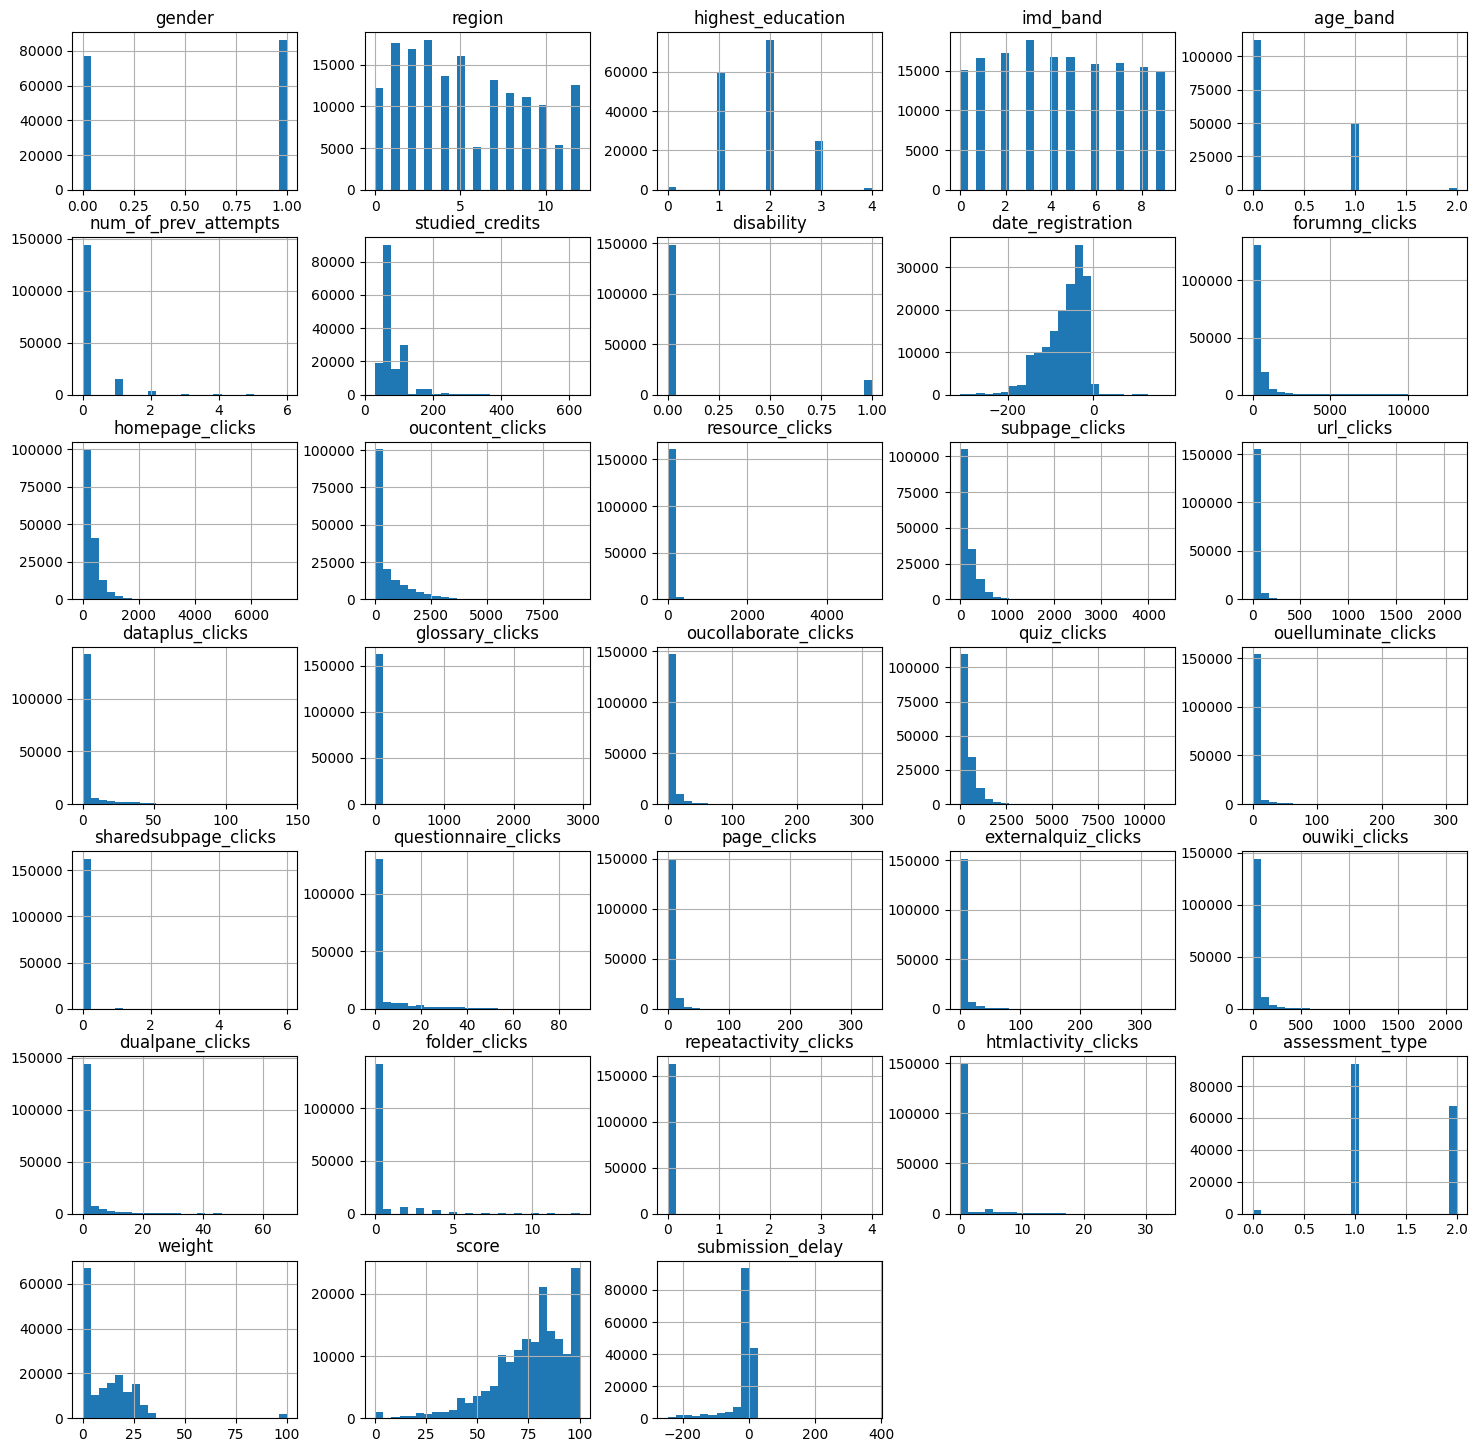

In [6]:
#showing the feature values
df.hist(layout=(7,5),figsize=(18, 18), bins=25)
plt.show()

With the previous step we have obtained a dataset containing only *integer values*.

We normalize every feature $f$ with values $vals$ and
- mean:  $mn$
- standard deviation:  $std$

with the following algorithm.

For each $v \in vals$:
$$
v := \frac{v - mn}{std}
$$

<!-- This step ensures that every value in the dataset is in the range $[0,1]$. -->

Let's also save the score for later computations using Neural Networks

In [7]:
y_nn = df["score"].tolist()

In [8]:
for col in df:
    print(f"Normalizing column '{col}'")
    print("\n==================================================\n")

    df[col] = (df[col] - df[col].mean()) / df[col].std()

Normalizing column 'gender'


Normalizing column 'region'


Normalizing column 'highest_education'


Normalizing column 'imd_band'


Normalizing column 'age_band'


Normalizing column 'num_of_prev_attempts'


Normalizing column 'studied_credits'


Normalizing column 'disability'


Normalizing column 'date_registration'


Normalizing column 'forumng_clicks'


Normalizing column 'homepage_clicks'


Normalizing column 'oucontent_clicks'


Normalizing column 'resource_clicks'


Normalizing column 'subpage_clicks'


Normalizing column 'url_clicks'


Normalizing column 'dataplus_clicks'


Normalizing column 'glossary_clicks'


Normalizing column 'oucollaborate_clicks'


Normalizing column 'quiz_clicks'


Normalizing column 'ouelluminate_clicks'


Normalizing column 'sharedsubpage_clicks'


Normalizing column 'questionnaire_clicks'


Normalizing column 'page_clicks'


Normalizing column 'externalquiz_clicks'


Normalizing column 'ouwiki_clicks'


Normalizing column 'dualpane_clicks'


Normali

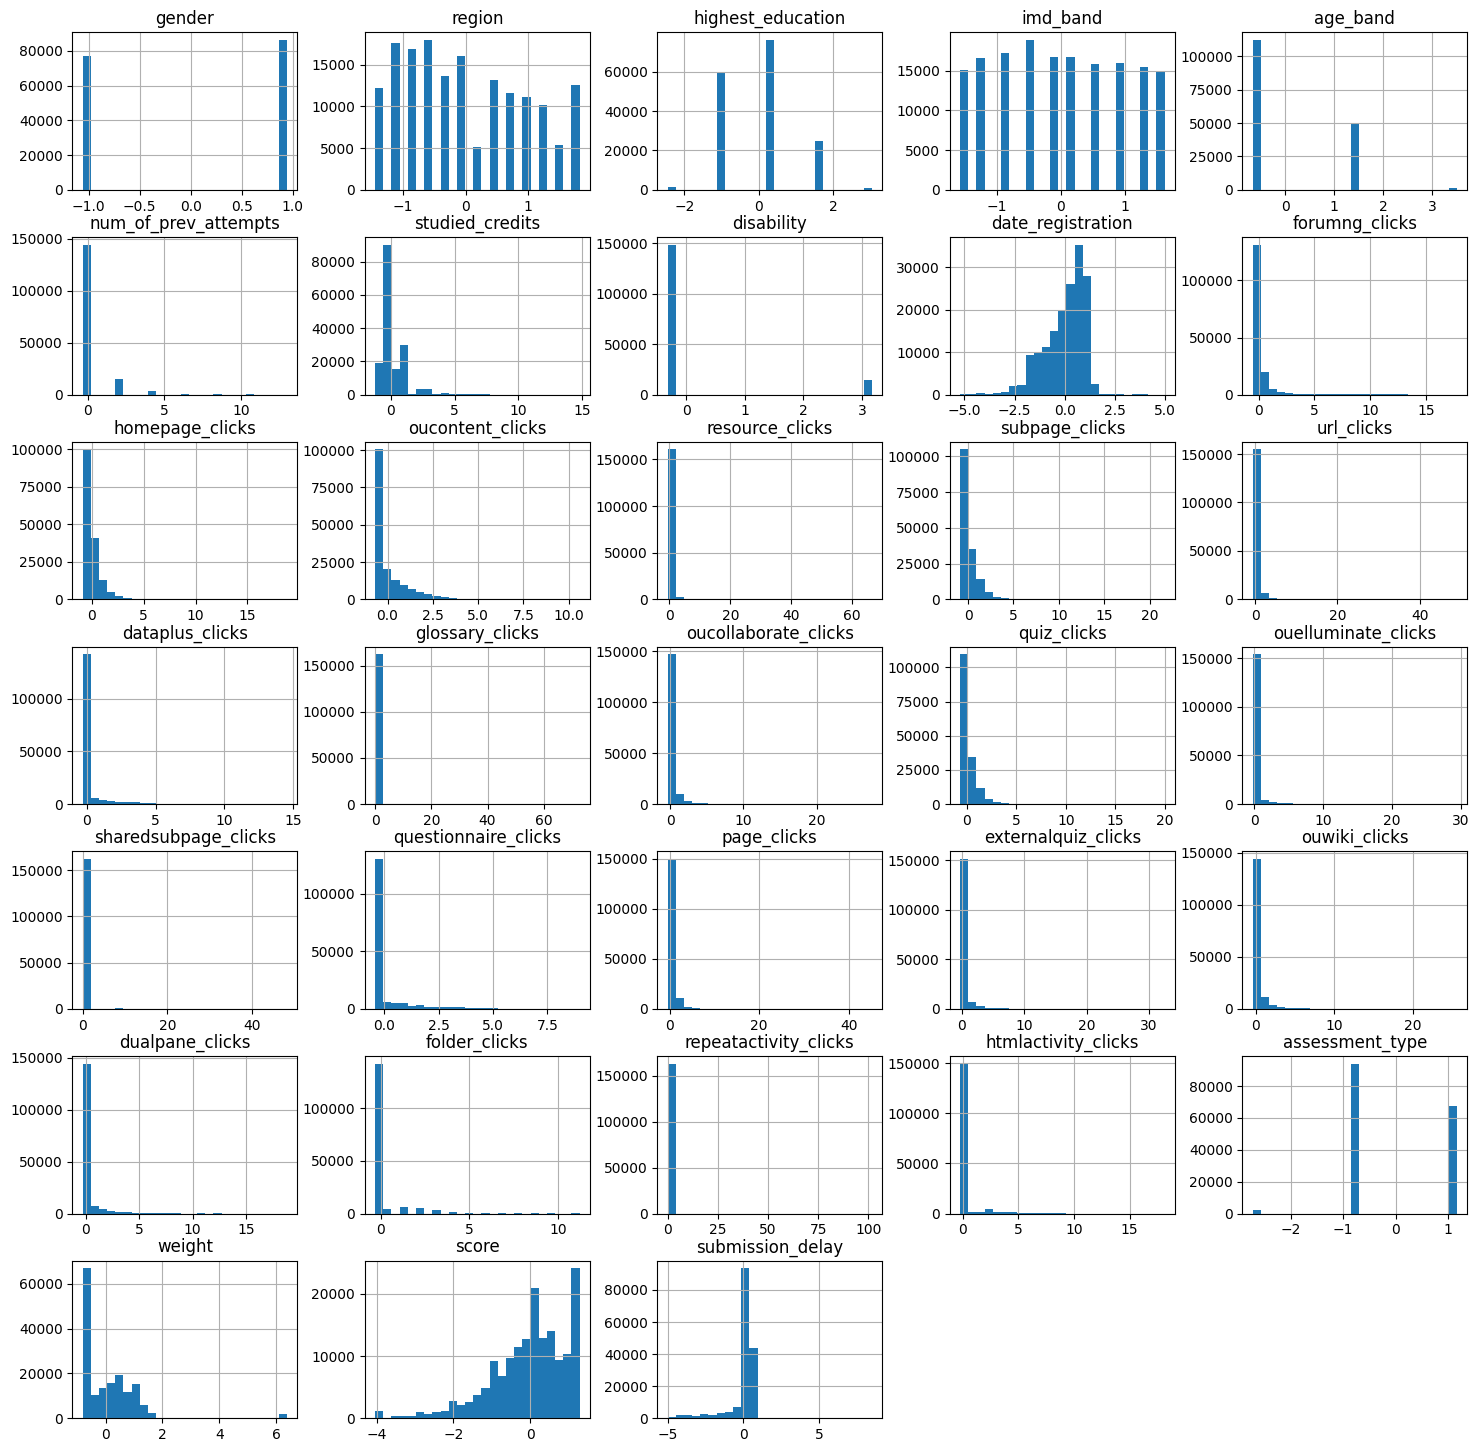

Column 'gender' has max value of 0.9446026980658498
Column 'region' has max value of 1.8189123422468756
Column 'highest_education' has max value of 3.0450965769712472
Column 'imd_band' has max value of 1.6279097821340263
Column 'age_band' has max value of 3.5125380037014544
Column 'num_of_prev_attempts' has max value of 13.007845039702666
Column 'studied_credits' has max value of 14.819496958952277
Column 'disability' has max value of 3.175616161701915
Column 'date_registration' has max value of 4.9770544172070315
Column 'forumng_clicks' has max value of 17.7757272371232
Column 'homepage_clicks' has max value of 18.820656142513954
Column 'oucontent_clicks' has max value of 10.597292648771141
Column 'resource_clicks' has max value of 66.56019757945391
Column 'subpage_clicks' has max value of 21.644176798963034
Column 'url_clicks' has max value of 49.08569973219772
Column 'dataplus_clicks' has max value of 14.55851262699177
Column 'glossary_clicks' has max value of 72.83521981498382
Colu

In [9]:
#showing the feature values after normalization
df.hist(layout=(7,5),figsize=(18, 18), bins=25)
plt.show()

for col in df:
    print(f"Column '{col}' has max value of {df[col].max()}")


In [10]:
df

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,forumng_clicks,...,externalquiz_clicks,ouwiki_clicks,dualpane_clicks,folder_clicks,repeatactivity_clicks,htmlactivity_clicks,assessment_type,weight,score,submission_delay
0,0.944603,-0.627249,1.670893,1.627910,3.512538,-0.32674,4.373748,-0.314898,-1.974627,-0.266182,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.779197,-0.086882,0.117325,0.340851
1,0.944603,-0.627249,1.670893,1.627910,3.512538,-0.32674,4.373748,-0.314898,-1.974627,-0.266182,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.779197,0.632217,0.490268,0.340851
2,0.944603,-0.627249,1.670893,1.627910,3.512538,-0.32674,4.373748,-0.314898,-1.974627,-0.266182,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.779197,0.632217,0.223880,0.319025
3,0.944603,-0.627249,1.670893,1.627910,3.512538,-0.32674,4.373748,-0.314898,-1.974627,-0.266182,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.779197,0.632217,0.490268,0.319025
4,0.944603,-0.627249,1.670893,1.627910,3.512538,-0.32674,4.373748,-0.314898,-1.974627,-0.266182,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.779197,1.351317,0.330435,0.297199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163382,-1.058640,1.275321,1.670893,0.205043,1.424631,-0.32674,-1.250886,-0.314898,0.818840,-0.380327,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,1.167032,-0.805982,1.289430,-0.881397
163383,-1.058640,1.275321,1.670893,0.205043,1.424631,-0.32674,-1.250886,-0.314898,0.818840,-0.380327,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,1.167032,-0.805982,1.289430,-0.139318
163384,-1.058640,1.275321,1.670893,0.205043,1.424631,-0.32674,-1.250886,-0.314898,0.818840,-0.380327,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.779197,-0.805982,0.223880,-0.161144
163385,-1.058640,1.275321,1.670893,0.205043,1.424631,-0.32674,-1.250886,-0.314898,0.818840,-0.380327,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.779197,-0.805982,0.223880,0.144418


To better understand the influence of each feature on the value we want to predict, we use some scatterplots to show the relationship between each single feature of the dataset and the score value for an assessment.

In [ ]:
for col in df:  
    if col=="score": continue  
    sns.relplot(data=df, x=col, y="score")
    plt.show()

We can see that there isn't a linear relationship between features and target, as we could imagine, so we don't expect linear models to perform very well.

We get the training and test sets for our ML models by splitting the dataset according to a given ratio between training and test samples. We choose to use 80% of the original number of samples for training and the remaining 20% for testing.

In [13]:
#using scikit-learn to split the dataset into train and test sets
X = df.drop("score", axis=1)
y = df["score"].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=7) #130709 train samples, 32678 test


X_train.to_csv("sets/X_train.csv")
X_test.to_csv("sets/X_test.csv")
y_train.to_csv("sets/y_train.csv")
y_test.to_csv("sets/y_test.csv")

## Regression

### Decision Trees

Decision trees are a simple ML model that we can use for the regression task of predicting the score of some student in an assessment.
This model should be able to deal with the non-linear relationship between the features and the target, thus achieving better results compared to linear regression. However, it might be prone to overfitting.

In [ ]:
#using the scikit-learn implementation of the model
from sklearn.tree import DecisionTreeRegressor


## Multinomial classification

### Neural Networks

Feature engineering using the following [link](https://www.kaggle.com/code/devassaxd/student-performance-prediction-complete-analysis)

In [46]:
studInfo=pd.read_csv("data/studentInfo.csv")
assessments=pd.read_csv("data/assessments.csv")
studAss=pd.read_csv("data/studentAssessment.csv")
studVle=pd.read_csv("data/studentVle.csv")
vle=pd.read_csv("data/vle.csv")

#### Assessments
The performance in each assessement is a good indicator of the students' knowledge of the course and, as it composes the grade for the final evaluation, it's interesting to make it a feature in the final model. But, as there are many different courses, each with a different structure, it's unfeasible to create a feature for each assessment. In order to include the assessments, we will build 2 features: One of them is the final grade given by the score and the weight of each assessment. The other is a pass rate, created on the premise that a student must get at least 40% score on an assessment to pass it, calculating the percentage of assessments the student sucessfully passed. We also will split final exams from the other assessments, given their status and participation in the final evaluation is different from the other assessments.

In [47]:
exams=assessments[assessments["assessment_type"]=="Exam"]
others=assessments[assessments["assessment_type"]!="Exam"]
amounts=others.groupby(["code_module","code_presentation"]).count()["id_assessment"] 
amounts=amounts.reset_index()
amounts.head()

,code_module,code_presentation,id_assessment
0,AAA,2013J,5
1,AAA,2014J,5
2,BBB,2013B,11
3,BBB,2013J,11
4,BBB,2014B,11


In [48]:
#Function to determine whether a student passed a given assessment
def pass_fail(grade):
    if grade>=40:
        return True
    else:
        return False
#Creating the stud_ass dataframe to join infos about the assessment weights and their respective grades
stud_ass=pd.merge(studAss,others,how="inner",on=["id_assessment"])
stud_ass["pass"]=stud_ass["score"].apply(pass_fail)
stud_ass["weighted_grade"]=stud_ass["score"]*stud_ass["weight"]/100

In [49]:
#Final assessment average per student per module
avg_grade=stud_ass.groupby(["id_student","code_module","code_presentation"]).sum()["weighted_grade"].reset_index()
avg_grade.head()

,id_student,code_module,code_presentation,weighted_grade
0,6516,AAA,2014J,63.50
1,8462,DDD,2013J,34.90
2,8462,DDD,2014J,43.00
3,11391,AAA,2013J,82.40
4,23629,BBB,2013B,16.69


In [50]:
#Pass rate per student per module
pass_rate=pd.merge((stud_ass[stud_ass["pass"]==True].groupby(["id_student","code_module","code_presentation"]).count()["pass"]).reset_index(),amounts,how="left",on=["code_module","code_presentation"])
pass_rate["pass_rate"]=pass_rate["pass"]/pass_rate["id_assessment"]
pass_rate.drop(["pass","id_assessment"], axis=1,inplace=True)
pass_rate.head()

,id_student,code_module,code_presentation,pass_rate
0,6516,AAA,2014J,1.000000
1,8462,DDD,2013J,0.500000
2,8462,DDD,2014J,0.666667
3,11391,AAA,2013J,1.000000
4,23629,BBB,2013B,0.363636


In [51]:
#Final exam scores
stud_exams=pd.merge(studAss,exams,how="inner",on=["id_assessment"])
stud_exams["exam_score"]=stud_exams["score"]
stud_exams.drop(["id_assessment","date_submitted","is_banked", "score","assessment_type","date","weight"],axis=1,inplace=True)
stud_exams.head()

,id_student,code_module,code_presentation,exam_score
0,558914,CCC,2014B,32.0
1,559706,CCC,2014B,78.0
2,559770,CCC,2014B,54.0
3,560114,CCC,2014B,64.0
4,560311,CCC,2014B,100.0


#### VLE
The datasets referring to the VLE (Virtual Learning Environment) contain the interaction feed of the students with the content available for reference throughout the duration of the period. From this data we can infer how in touch a student was with their subjects, whether they studied it on a solid basis and how they used the content.

In [52]:
vle

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN
...,...,...,...,...,...,...
6359,897063,GGG,2014J,resource,NaN,NaN
6360,897109,GGG,2014J,resource,NaN,NaN
6361,896965,GGG,2014J,oucontent,NaN,NaN
6362,897060,GGG,2014J,resource,NaN,NaN


In [53]:
vle[~vle["week_from"].isna()]
#Only 1121 from the 6364 entries have the reference week for the materials (the week in which they would be used in course.)
#With this in mind, the construction of a metric to track study commitment becomes impractical

,id_site,code_module,code_presentation,activity_type,week_from,week_to
113,546732,AAA,2013J,oucontent,2.0,2.0
198,546719,AAA,2013J,oucontent,1.0,1.0
210,546681,AAA,2013J,oucontent,1.0,1.0
264,877040,AAA,2014J,oucontent,2.0,2.0
323,877045,AAA,2014J,oucontent,1.0,1.0
...,...,...,...,...,...,...
6243,798728,GGG,2014B,resource,1.0,1.0
6266,897051,GGG,2014J,resource,2.0,2.0
6285,897121,GGG,2014J,resource,1.0,1.0
6304,897050,GGG,2014J,resource,1.0,1.0


In [54]:
studVle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [55]:
#Here we can track the average time after the start of the course the student took to use the materials
#and the average amount of clicks per material
avg_per_site=studVle.groupby(["id_student","id_site","code_module","code_presentation"]).mean().reset_index()
avg_per_site.head()

,id_student,id_site,code_module,code_presentation,date,sum_click
0,6516,877011,AAA,2014J,210.333333,3.833333
1,6516,877012,AAA,2014J,90.833333,2.310606
2,6516,877015,AAA,2014J,113.461538,2.000000
3,6516,877023,AAA,2014J,122.666667,2.000000
4,6516,877025,AAA,2014J,41.142857,4.333333


In [56]:
#General average per student per module
avg_per_student=avg_per_site.groupby(["id_student","code_module","code_presentation"]).mean()[["date","sum_click"]].reset_index()
avg_per_student.head()

,id_student,code_module,code_presentation,date,sum_click
0,6516,AAA,2014J,105.292573,5.816135
1,8462,DDD,2013J,38.794704,1.734524
2,8462,DDD,2014J,10.000000,3.000000
3,11391,AAA,2013J,111.739069,4.231515
4,23629,BBB,2013B,33.409632,2.817316


#### StudentInfo

The studentInfo table contains various info about the students, but the relevant ones for this analysis are:

- The amount of times the student has already tried to finish the module
- The students' final result

The last one is our interest variable as we build our prediction model

In [57]:
#Removing the cases where the student has withdrawn their registration to the module
studInfo=studInfo[studInfo["final_result"]!="Withdrawn"]
studInfo=studInfo[["code_module","code_presentation","id_student","num_of_prev_attempts","final_result"]]
studInfo.head()

,code_module,code_presentation,id_student,num_of_prev_attempts,final_result
0,AAA,2013J,11391,0,Pass
1,AAA,2013J,28400,0,Pass
3,AAA,2013J,31604,0,Pass
4,AAA,2013J,32885,0,Pass
5,AAA,2013J,38053,0,Pass


#### Compiling all relevant tables

In [58]:
df_1=pd.merge(avg_grade,pass_rate,how="inner",on=["id_student","code_module","code_presentation"])
assessment_info=pd.merge(df_1, stud_exams, how="inner", on=["id_student","code_module","code_presentation"])
assessment_info.head()

,id_student,code_module,code_presentation,weighted_grade,pass_rate,exam_score
0,23698,CCC,2014J,69.97,1.000000,80.0
1,24213,DDD,2014B,78.40,1.000000,58.0
2,27116,CCC,2014J,92.02,1.000000,96.0
3,28046,DDD,2013J,49.90,0.833333,40.0
4,28787,CCC,2014J,11.98,0.375000,44.0


In [59]:
df_2=pd.merge(studInfo,assessment_info,how="inner",on=["id_student","code_module","code_presentation"])
final_df=pd.merge(df_2,avg_per_student,how="inner", on=["id_student","code_module","code_presentation"])
final_df.drop(["id_student","code_module","code_presentation"],axis=1,inplace=True)
final_df.head()
#The final dataframe only has information relevant to the problem

,num_of_prev_attempts,final_result,weighted_grade,pass_rate,exam_score,date,sum_click
0,0,Distinction,89.65,1.000,94.0,103.457907,2.706754
1,0,Pass,84.58,1.000,76.0,87.617265,1.539047
2,0,Pass,51.44,0.625,66.0,49.181286,1.562619
3,0,Pass,75.13,1.000,50.0,118.698642,2.189217
4,0,Distinction,93.22,1.000,98.0,75.791987,2.100617


Delete some outliers to have the most uniform dataset possible

In [60]:
final_df=final_df[final_df["sum_click"]<=10]
final_df=final_df[final_df["num_of_prev_attempts"]<=4]
final_df.head()

,num_of_prev_attempts,final_result,weighted_grade,pass_rate,exam_score,date,sum_click
0,0,Distinction,89.65,1.000,94.0,103.457907,2.706754
1,0,Pass,84.58,1.000,76.0,87.617265,1.539047
2,0,Pass,51.44,0.625,66.0,49.181286,1.562619
3,0,Pass,75.13,1.000,50.0,118.698642,2.189217
4,0,Distinction,93.22,1.000,98.0,75.791987,2.100617


In [ ]:
X=final_df.drop("final_result", axis=1)
y=final_df["final_result"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch
import torch.nn as nn
import torch.optim as optim

In [31]:
class StudentDataset(Dataset):

    def __init__(self, X, y, transform=None, percentage = 1):
        self.X = X.values.tolist()
        self.y = y

        if percentage != 1:
            self.X = self.X[:int(len(self.X)*percentage)]
            self.y = self.y[:int(len(self.y)*percentage)]

    def __len__(self):
        return len(self.X)
        

    def __getitem__(self, idx):
        x_sample = torch.tensor(self.X[idx])
        y_sample = torch.zeros(10)
        if int(self.y[idx]/10) == 10:
            y_sample[9] = 1
        else:
            y_sample[int(self.y[idx]/10)] = 1

        return x_sample, y_sample
        

In [36]:
dataset_train = StudentDataset(X_train, y_train)
dataset_test = StudentDataset(X_test, y_test)

In [38]:
dataloader_train = DataLoader(dataset_train, batch_size=16,
                        shuffle=True, num_workers=0)

dataloader_test = DataLoader(dataset_test, batch_size=16,
                        shuffle=True, num_workers=0)

In [19]:
x, y = dataset_train[0]
in_features = len(x)
out_features = len(y)

In [23]:
class StudentScoreClassifier(nn.Module):
    def __init__(self):
        super(StudentScoreClassifier, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features, in_features * 4),
            nn.ReLU(),
            nn.Linear(in_features*4, in_features * 8),
            nn.ReLU(),
            nn.Linear(in_features*8, in_features * 4),
            nn.ReLU(),
            nn.Linear(in_features*4, out_features),
            nn.Softmax()
        )

    def forward(self, x):
        return self.model(x)

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = StudentScoreClassifier().to(device)
epochs = 1000

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    corrects = 0.0
    for i, data in enumerate(dataloader_train):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        _, preds = torch.max(outputs.data, 1)
        _, correct_labels = torch.max(labels.data ,1)
        """print(preds)
        print(correct_labels)
        print("=================================")"""

        corrects += float(torch.sum(preds == correct_labels))
        
    print("EPOCH {} \t LOSS: {:.3f} \t ACCURACY: {:.3f}".format(epoch+1, running_loss/len(dataset_train), corrects/len(dataset_train)) )

print('Finished Training')

In [41]:
model.eval()

for i, data in enumerate(dataloader_test):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward + backward + optimize
    outputs = model(inputs)

    _, preds = torch.max(outputs.data, 1)
    _, correct_labels = torch.max(labels.data ,1)

    corrects += float(torch.sum(preds == correct_labels))

print("Precision: {:.3f}".format(corrects/len(dataset_test)))

C:\Users\stefa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Precision: 0.294
